In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.competition_download_file('time-series-classification-part-1','ETTh1_without_missing.csv')

100%|██████████| 753k/753k [00:00<00:00, 1.13MB/s]

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Charger les données
df = pd.read_csv("ETTh1_without_missing.csv")

# Convertir la colonne de dates en DateTime
df['date'] = pd.to_datetime(df['date'])

# Extraire les composantes temporelles
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

# Supprimer la colonne de date d'origine
df = df.drop(columns=['date'])

# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Définir les caractéristiques et la cible
X = scaled_data[:, :-1]  # Toutes les colonnes sauf la dernière
y = scaled_data[:, -1]   # Dernière colonne (température)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape des données pour les modèles LSTM (batch_size, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Définition du modèle LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilation du modèle
model.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Prédiction sur l'ensemble de test
print(X_test[0])
y_pred = model.predict(X_test)
print(y_pred[0])

# Calcul de la MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


2024-03-07 13:53:57.783799: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 13:53:57.805148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 13:53:57.805169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 13:53:57.805939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 13:53:57.809670: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 13:53:57.810336: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/50
433/433 - 2s - loss: 0.1023 - val_loss: 0.0908 - 2s/epoch - 4ms/step
Epoch 2/50
433/433 - 1s - loss: 0.0911 - val_loss: 0.0903 - 540ms/epoch - 1ms/step
Epoch 3/50
433/433 - 1s - loss: 0.0908 - val_loss: 0.0898 - 535ms/epoch - 1ms/step
Epoch 4/50
433/433 - 1s - loss: 0.0906 - val_loss: 0.0893 - 541ms/epoch - 1ms/step
Epoch 5/50
433/433 - 1s - loss: 0.0905 - val_loss: 0.0895 - 535ms/epoch - 1ms/step
Epoch 6/50
433/433 - 1s - loss: 0.0905 - val_loss: 0.0898 - 531ms/epoch - 1ms/step
Epoch 7/50
433/433 - 1s - loss: 0.0905 - val_loss: 0.0894 - 533ms/epoch - 1ms/step
Epoch 8/50
433/433 - 1s - loss: 0.0906 - val_loss: 0.0893 - 531ms/epoch - 1ms/step
Epoch 9/50
433/433 - 1s - loss: 0.0905 - val_loss: 0.0893 - 530ms/epoch - 1ms/step
Epoch 10/50
433/433 - 1s - loss: 0.0906 - val_loss: 0.0892 - 535ms/epoch - 1ms/step
Epoch 11/50
433/433 - 1s - loss: 0.0904 - val_loss: 0.0891 - 539ms/epoch - 1ms/step
Epoch 12/50
433/433 - 1s - loss: 0.0905 - val_loss: 0.0894 - 528ms/epoch - 1ms/step
Epoc

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
df = pd.read_csv("ETTh1_without_missing.csv")
# Générer les 100 dates consécutives suivantes à partir de la dernière date dans le dataframe
last_date = df['date'].iloc[-1]
last_row = df.iloc[-1]
future_dates = pd.date_range(start=last_date, periods=100, freq='H').tolist()

# Séparer les dates en année, mois, jour et heure
future_years = [date.year for date in future_dates]
future_months = [date.month for date in future_dates]
future_days = [date.day for date in future_dates]
future_hours = [date.hour for date in future_dates]

# Obtenir les valeurs de l'ID et de la température pour les futures dates
future_ids = [last_row['Id']] * 100
future_temperatures = [last_row['OT']] * 100

# Combiner toutes les caractéristiques pour les futures dates
future_features = np.column_stack((future_ids, future_years, future_months, future_days, future_hours, future_temperatures))

# Utiliser le MinMaxScaler pour normaliser les nouvelles dates
future_dates_normalized = scaler.transform(future_features)

# Effectuer les prédictions pour les 100 prochaines valeurs de température
ot = []
# Utiliser la dernière entrée comme base pour la prédiction
last_input = np.array([last_100_steps[:, -1]])
for i in range(100):
    # Prédiction pour le prochain pas de temps
    next_pred = model.predict([last_input, np.array(future_dates_normalized[i]).reshape(1, 1)])
    ot.append(next_pred[0, 0])
    # Mettre à jour last_input avec la nouvelle prédiction et la date correspondante
    last_input = np.concatenate((last_input[:, 1:], next_pred.reshape(1, 1, 1)), axis=1)

# Inverser la normalisation pour obtenir les valeurs de température réelles
future_predictions = scaler.inverse_transform(np.array(ot).reshape(-1, 1))

# Créer un DataFrame pour stocker les prédictions avec les dates correspondantes
future_df = pd.DataFrame({'date': future_dates, 'OT': future_predictions.flatten()})

# Enregistrer les prédictions dans un fichier CSV
future_df.to_csv("future_predictions.csv", index=False)

/tmp/ipykernel_16455/2459392389.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date, periods=100, freq='H').tolist()
/home/flo/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


NameError: name 'last_100_steps' is not defined

In [83]:
import pandas as pd

df = pd.read_csv('ETTh1_without_missing.csv')
df['date'] = pd.to_datetime(df['date'])
df


,Id,date,OT
0,0,2016-07-01 00:00:00,30.531000
1,1,2016-07-01 01:00:00,27.787001
2,2,2016-07-01 02:00:00,27.787001
3,3,2016-07-01 03:00:00,25.044001
4,4,2016-07-01 04:00:00,21.948000
...,...,...,...
17315,17315,2018-06-22 11:00:00,6.753000
17316,17316,2018-06-22 12:00:00,3.658000
17317,17317,2018-06-22 13:00:00,3.658000
17318,17318,2018-06-22 14:00:00,4.150000


In [84]:
import numpy as np

# Trouver la dernière date dans le dataframe
derniere_date = df['date'].iloc[-1]
dernier_id = df['Id'].iloc[-1]
# Créer une liste de 100 nouvelles dates à partir de la dernière date
nouvelles_dates = pd.date_range(start=derniere_date, periods=100, freq='H').tolist()

# Créer une liste de 100 nouveaux ID à partir du dernier ID
nouveaux_ids = range(dernier_id + 1, dernier_id + 101)

# Créer un dataframe temporaire avec les nouvelles dates, les nouveaux IDs et les valeurs NaN pour la colonne 'OT'
df_nouvelles_dates = pd.DataFrame({'Id': nouveaux_ids, 'date': nouvelles_dates, 'OT': np.nan})
# Concaténer le dataframe temporaire avec le dataframe existant
# df = pd.concat([df, df_nouvelles_dates], ignore_index=True)

# Afficher le dataframe avec les nouvelles dates ajoutées
df_nouvelles_dates


/tmp/ipykernel_8166/526410066.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nouvelles_dates = pd.date_range(start=derniere_date, periods=100, freq='H').tolist()


,Id,date,OT
0,17320,2018-06-22 15:00:00,NaN
1,17321,2018-06-22 16:00:00,NaN
2,17322,2018-06-22 17:00:00,NaN
3,17323,2018-06-22 18:00:00,NaN
4,17324,2018-06-22 19:00:00,NaN
...,...,...,...
95,17415,2018-06-26 14:00:00,NaN
96,17416,2018-06-26 15:00:00,NaN
97,17417,2018-06-26 16:00:00,NaN
98,17418,2018-06-26 17:00:00,NaN


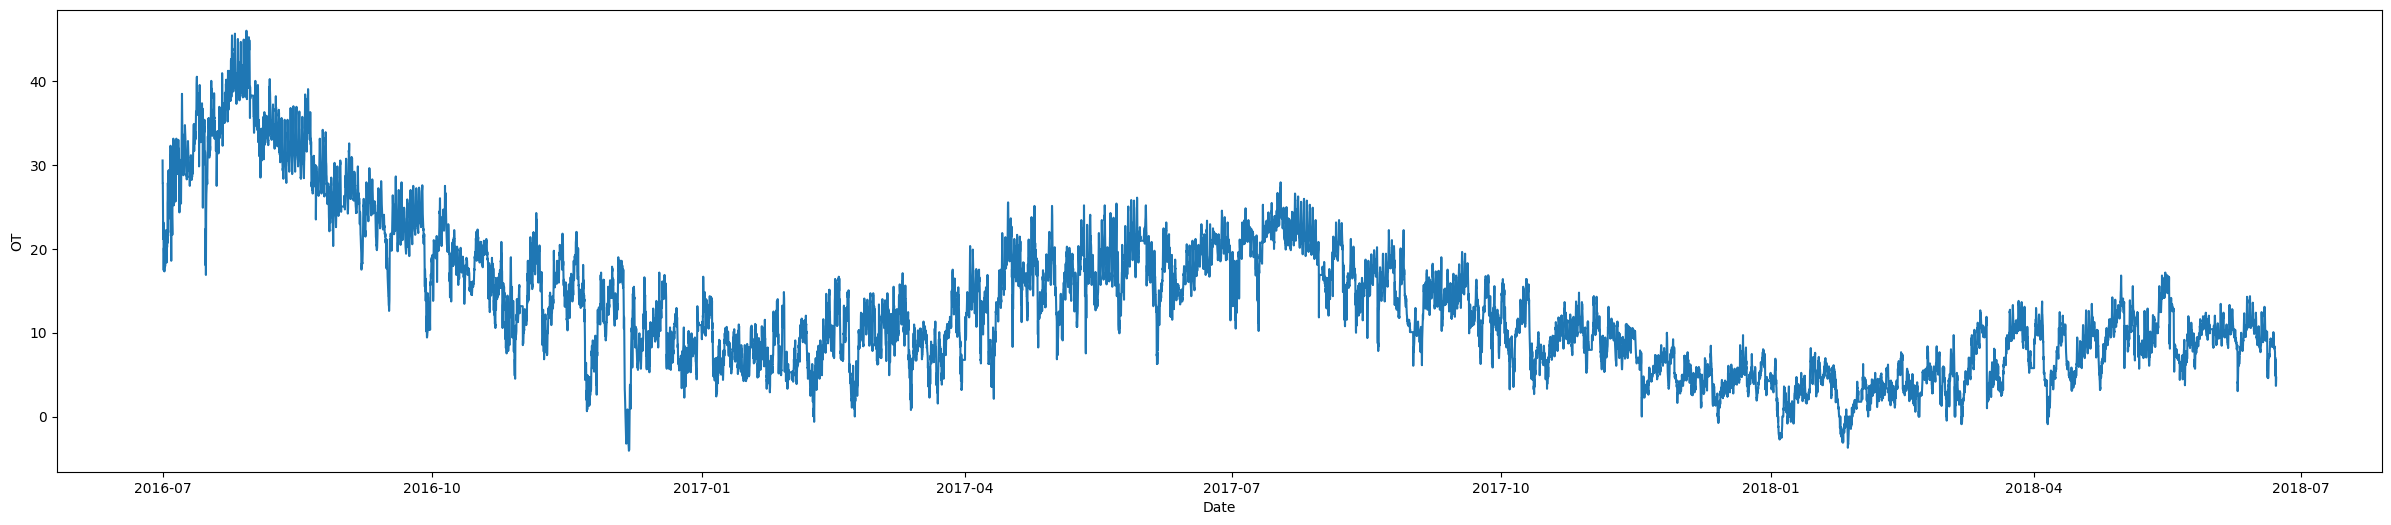

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 6))
sns.lineplot(data=df[['date', 'OT']], x='date', y='OT', legend=False)
plt.xlabel('Date')
plt.ylabel('OT')
plt.title(f"")
# plt.gca().invert_yaxis()
plt.show()

In [85]:
df = df.loc[df['Id'] > 5000]

In [86]:
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
import tensorflow as tf

df['OT'] = df['OT'].astype('float32')
df['Id'] = df['Id'].astype('int32')
df.dropna(inplace=True)
# Extract the targets (OT values) from the data
targets = df['OT'].values
# print(targets)
# Stack the years, months, days, and hours into a numpy array
reference_date = pd.Timestamp("1970-01-01")
input = (df['date'] - reference_date).dt.total_seconds()/(10**10)
print(input)

# Split the data into training and testing sets
# 80% of the data will be used for training and 20% for testing
# Data is split randomly, with random_state=42 to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(input, targets, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(np.array(X_train), np.array(y_train), test_size=0.2)
print(X_train)
# Create TensorFlow datasets from arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size_value = 64
# Shuffle and batch the training data
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size_value)

# Batch the validation and test data
val_dataset = val_dataset.batch(batch_size_value)
test_dataset = test_dataset.batch(batch_size_value)

# Affichage des tailles des ensembles d'entraînement et de test
print("Train set length :", len(X_train), "samples")
print("Validation set length :", len(X_val), "samples")
print("Test set length :", len(X_test), "samples")
print("Total :", len(X_train)+len(X_test)+len(X_val), "samples")

5001     0.148533
5002     0.148534
5003     0.148534
5004     0.148535
5005     0.148535
           ...   
17315    0.152967
17316    0.152967
17317    0.152967
17318    0.152968
17319    0.152968
Name: date, Length: 12319, dtype: float64
[0.15078708 0.14953104 0.1499958  ... 0.15283944 0.15290424 0.15217596]
Train set length : 7884 samples
Validation set length : 1971 samples
Test set length : 2464 samples
Total : 12319 samples


/tmp/ipykernel_8166/2802308663.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OT'] = df['OT'].astype('float32')
/tmp/ipykernel_8166/2802308663.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Id'] = df['Id'].astype('int32')
/tmp/ipykernel_8166/2802308663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

In [87]:
import tensorflow as tf
# Model creation
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)  
])

# Compilation
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, np.array(y_val)))

# Evaluation
loss, mae = model.evaluate(X_test, np.array(y_test))
print("Test loss :", loss)
print("Test MAE :", mae)


Epoch 1/50
247/247 [==============================] - 1s 2ms/step - loss: 67.5706 - mae: 6.5146 - val_loss: 35.8419 - val_mae: 5.0217
Epoch 2/50
247/247 [==============================] - 0s 1ms/step - loss: 35.6314 - mae: 4.8956 - val_loss: 35.9149 - val_mae: 5.0355
Epoch 3/50
247/247 [==============================] - 0s 1ms/step - loss: 35.6181 - mae: 4.9013 - val_loss: 35.9934 - val_mae: 5.0484
Epoch 4/50
247/247 [==============================] - 0s 1ms/step - loss: 35.7302 - mae: 4.9103 - val_loss: 35.7837 - val_mae: 5.0092
Epoch 5/50
247/247 [==============================] - 0s 1ms/step - loss: 35.6853 - mae: 4.9046 - val_loss: 35.8437 - val_mae: 4.9475
Epoch 6/50
247/247 [==============================] - 0s 1ms/step - loss: 35.6110 - mae: 4.8967 - val_loss: 35.7005 - val_mae: 4.9796
Epoch 7/50
247/247 [==============================] - 0s 1ms/step - loss: 35.5987 - mae: 4.8967 - val_loss: 35.8426 - val_mae: 4.9471
Epoch 8/50
247/247 [==============================] - 0s 1ms/s

In [340]:
def preprocess_next_date(date, hour):
    
    years = int(date.split("-")[0])
    months = int(date.split("-")[1])
    days = int(date.split("-")[2])

    return np.array([[years, months, days, hour]])

In [341]:
def predict_next_100_values(filename):
    fields = ["Id", "OT"]

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(fields)
        
        for i in range(100):
            csv_line = []
            date = next_100_dates[i].split(" ")[0]
            hour = int(next_100_dates[i].split(" ")[1].split(":")[0])
            new_value_prediction = model.predict(preprocess_next_date(date, hour))
            csv_line = [i, float(new_value_prediction)]
            writer.writerow(csv_line)
    print(f"CSV file '{filename}' successfully created.")

filename = "neural_network_prediction.csv"
predict_next_100_values(filename)

1/1 [==============================] - 0s 21ms/step
CSV file 'neural_network_prediction.csv' successfully created.
